In [ ]:
!!pip install -q git+https://github.com/keras-team/keras-hub.git
!!pip install -q --upgrade keras  

['\x1b[?25l   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.2 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.2/1.2 MB\x1b \x1b43.2 MB/s\x1b eta \x1b0:00:00\x1b',
 "\x1b[?25h\x1bERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.",
 'tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.\x1b\x1b',
 '\x1b']

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics
from keras.applications.imagenet_utils import decode_predictions
import keras_hub

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds


In [3]:
classifier = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet")

100%|██████████| 840/840 [00:00<00:00, 1.92MB/s]


100%|██████████| 3.54k/3.54k [00:00<00:00, 2.77MB/s]


100%|██████████| 98.1M/98.1M [00:07<00:00, 13.8MB/s]


100%|██████████| 90.2M/90.2M [00:06<00:00, 13.5MB/s]


In [4]:
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )
        return ops.where(step > self.total_steps, 0.0, lr)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Parameters
BATCH_SIZE = 64
IMAGE_SIZE = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 4
NUM_FOLDS = 5
EPOCHS = 30
GAMMA = 1.5


In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='int'
)

images = []
labels = []
for image, label in dataset:
    images.append(image[0])
    labels.append(label[0])


images = np.array([img.numpy() for img in images])
labels = np.array([lbl.numpy() for lbl in labels])

# Check the shape to confirm
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Found 330 files belonging to 4 classes.
Images shape: (330, 256, 256, 3)
Labels shape: (330,)


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

def augment_dataset(images, labels, gamma_value):
    gamma_images = tf.image.adjust_gamma(images, gamma=gamma_value).numpy()
    augmented_images = np.concatenate((images, gamma_images), axis=0)
    augmented_labels = np.concatenate((labels, labels), axis=0)
    return augmented_images, augmented_labels

def visualize_gamma_augmentation(images, gamma_value):
    gamma_images = tf.image.adjust_gamma(images, gamma=gamma_value).numpy()

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        axes[0, i].imshow(images[i].astype("uint8"))
        axes[0, i].axis("off")
        axes[0, i].set_title("Original")

        axes[1, i].imshow(gamma_images[i].astype("uint8"))
        axes[1, i].axis("off")
        axes[1, i].set_title(f"Gamma: {gamma_value}")

    plt.suptitle("Gamma Augmentation Visualization")
    plt.tight_layout()
    plt.show()

def augment_and_check(images, labels, gamma_value):
    print(f"Original dataset size: {len(images)} images")
    augmented_images, augmented_labels = augment_dataset(images, labels, gamma_value)
    print(f"Dataset size after augmentation: {len(augmented_images)} images")

    visualize_gamma_augmentation(images, gamma_value)
    return augmented_images, augmented_labels

gamma_value_to_check = 1.5
augmented_images, augmented_labels = augment_and_check(images[:10], labels[:10], gamma_value_to_check) 

In [ ]:
# from sklearn.model_selection import KFold
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf

# # Hyperparameters and initialization
# gamma_values = [1.2, 1.4, 1.5]  # Gamma values to test
# batch_size = 64
# BATCH_SIZE = 64
# EPOCHS = 15
# NUM_CLASSES = 4
# AUTOTUNE = tf.data.AUTOTUNE
# IMAGE_SIZE = (224, 224)  # Define image size for resizing

# # Nested CV setup
# outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
# inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# # Store results
# outer_results = []
# validation_histories = []  # Track validation accuracy for each gamma

# # Define function for dataset augmentation
# def augment_dataset(images, labels, gamma_value):
#     gamma_images = tf.image.adjust_gamma(images, gamma=gamma_value).numpy()
#     augmented_images = np.concatenate((images, gamma_images), axis=0)
#     augmented_labels = np.concatenate((labels, labels), axis=0)
#     return augmented_images, augmented_labels

# # Load and preprocess dataset
# def load_dataset(directory, image_size):
#     dataset = tf.keras.preprocessing.image_dataset_from_directory(
#         directory,
#         image_size=image_size,
#         label_mode="int",
#         batch_size=None,  # No batching here, we'll handle batching later
#     )
#     images = []
#     labels = []
#     for image, label in dataset:
#         images.append(image)
#         labels.append(label)
#     images = np.stack(images)
#     labels = np.array(labels)
#     return images, labels

# # Read dataset
# images, labels = load_dataset("/content/drive/MyDrive/praeciso/tt", IMAGE_SIZE)
# print("Images shape:", images.shape)
# print("Labels shape:", labels.shape)

# # Outer CV loop
# for outer_fold, (train_val_idx, test_idx) in enumerate(outer_cv.split(images)):
#     gamma_value = gamma_values[outer_fold % len(gamma_values)]  # Assign gamma value for this fold
#     print(f"Outer Fold {outer_fold + 1}: Using Gamma Value = {gamma_value}")

#     # Split data into train+val and test sets
#     X_train_val, X_test = images[train_val_idx], images[test_idx]
#     y_train_val, y_test = labels[train_val_idx], labels[test_idx]

#     # Augment the training+validation dataset with the selected gamma value
#     aug_train_val_images, aug_train_val_labels = augment_dataset(X_train_val, y_train_val, gamma_value)

#     best_inner_model = None
#     best_inner_accuracy = 0
#     fold_validation_accuracies = []

#     # Inner CV loop
#     for inner_fold, (train_idx, val_idx) in enumerate(inner_cv.split(aug_train_val_images)):
#         # Split into train and validation sets
#         X_train, X_val = aug_train_val_images[train_idx], aug_train_val_images[val_idx]
#         y_train, y_val = aug_train_val_labels[train_idx], aug_train_val_labels[val_idx]

#         # Create TF datasets
#         train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#         train_dataset = train_dataset.batch(batch_size).prefetch(AUTOTUNE)

#         val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
#         val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)

#         # Define and compile the model
#         base_model = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet", num_classes=4, trainable=True)
#         inputs = tf.keras.Input(shape=(224, 224, 3))
#         x = base_model(inputs)
#         outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
#         model = tf.keras.Model(inputs, outputs)

#         print("Length of augmented training + validation images:", len(aug_train_val_images))
#         print("Length of augmented training + validation labels:", len(aug_train_val_labels))

#         total_images = len(aug_train_val_images)
#         total_steps = (total_images // BATCH_SIZE) * EPOCHS
#         warmup_steps = int(0.1 * total_steps)
#         hold_steps = int(0.45 * total_steps)
#         schedule = WarmUpCosineDecay(
#             start_lr=0.05,
#             target_lr=1e-2,
#             warmup_steps=warmup_steps,
#             total_steps=total_steps,
#             hold=hold_steps,
#         )
#         model.compile(
#             loss="sparse_categorical_crossentropy",
#             optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
#             metrics=["accuracy"],
#         )

#         # Train the model
#         history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=1)

#         # Store validation accuracy for plotting
#         fold_validation_accuracies.append(history.history["val_accuracy"])

#         # Evaluate validation accuracy
#         val_accuracy = history.history["val_accuracy"][-1]
#         print(f"Inner Fold {inner_fold + 1}: Validation Accuracy = {val_accuracy}")

#         # Update best model for inner loop
#         if val_accuracy > best_inner_accuracy:
#             best_inner_accuracy = val_accuracy
#             best_inner_model = model.get_weights()

#     # Track validation history for visualization
#     validation_histories.append(fold_validation_accuracies)

#     # Test the best model from inner CV on the outer test set
#     best_model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     best_model.set_weights(best_inner_model)

#     # Recompile the model after loading weights
#     best_model.compile(
#         loss="sparse_categorical_crossentropy",
#         optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#         metrics=["accuracy"],
#     )

#     # Evaluate on the test set
#     test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
#     test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)
#     test_accuracy = best_model.evaluate(test_dataset, verbose=0)[1]
#     print(f"Outer Fold {outer_fold + 1}: Test Accuracy = {test_accuracy}")
#     outer_results.append(test_accuracy)

#     # Plot validation accuracy progression
#     plt.figure(figsize=(10, 5))
#     for idx, gamma_acc in enumerate(fold_validation_accuracies):
#         plt.plot(gamma_acc, label=f"Inner Fold {idx + 1}")
#     plt.title(f"Outer Fold {outer_fold + 1}: Validation Accuracy Progression")
#     plt.xlabel("Epochs")
#     plt.ylabel("Accuracy")
#     plt.legend()
#     plt.show()

# # Final results
# print(f"Nested CV Average Accuracy: {np.mean(outer_results)}")


Found 330 files belonging to 4 classes.
Images shape: (330, 224, 224, 3)
Labels shape: (330,)
Outer Fold 1: Using Gamma Value = 1.2
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 92s 12s/step - accuracy: 0.2454 - loss: 1.3881 - val_accuracy: 0.3401 - val_loss: 1.3773
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 758ms/step - accuracy: 0.4592 - loss: 1.3216 - val_accuracy: 0.4558 - val_loss: 1.3157
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 557ms/step - accuracy: 0.4599 - loss: 1.2448 - val_accuracy: 0.4558 - val_loss: 1.2586
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 565ms/step - accuracy: 0.4573 - loss: 1.1862 - val_accuracy: 0.4558 - val_loss: 1.2336
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 566ms/step - accuracy: 0.4573 - loss: 1.1313 - val_accuracy: 0.4558 - val_loss: 1.1990
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 593ms/step - accuracy: 0.4620 - loss: 1.0597 - val_accuracy: 0.4558 - val_loss: 1.1696
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 566ms/step - accuracy: 0.5350 - loss: 0.9945 - val_accuracy: 0.5578 - val

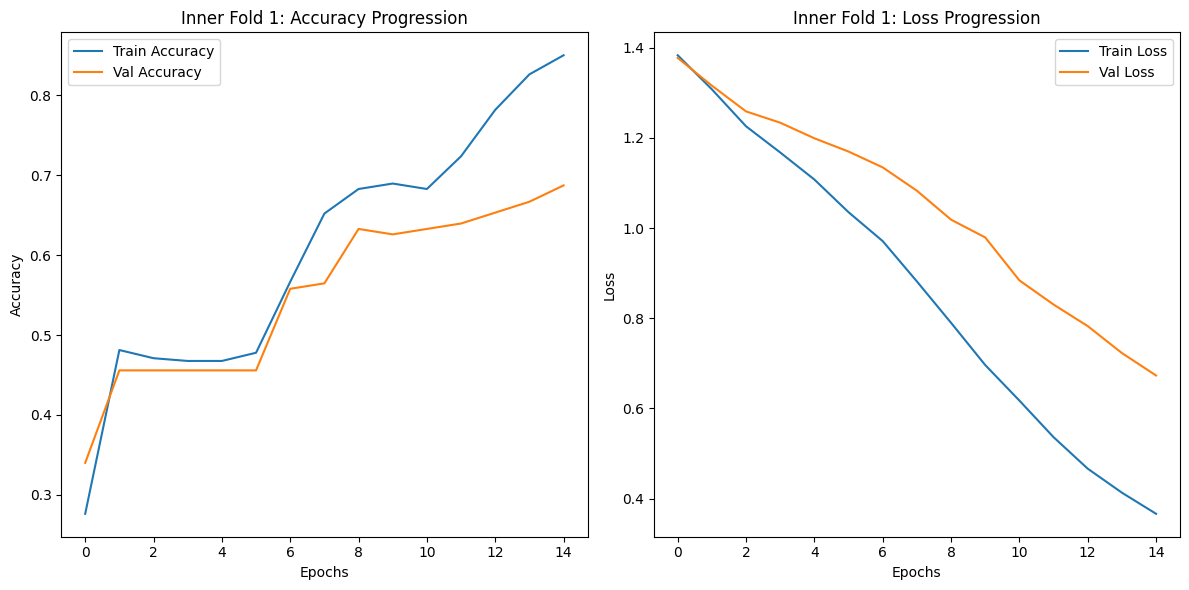

Inner Fold 1: Validation Accuracy = 0.6870748400688171
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.4274 - loss: 1.3532 - val_accuracy: 0.4694 - val_loss: 1.3337
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 550ms/step - accuracy: 0.4442 - loss: 1.3108 - val_accuracy: 0.4694 - val_loss: 1.2811
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 563ms/step - accuracy: 0.4442 - loss: 1.2451 - val_accuracy: 0.4694 - val_loss: 1.2549
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 570ms/step - accuracy: 0.4442 - loss: 1.2089 - val_accuracy: 0.4694 - val_loss: 1.2382
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 590ms/step - accuracy: 0.4453 - loss: 1.1568 - val_accuracy: 0.4694 - val_loss: 1.2013
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 590ms/step - accuracy: 0.4784 - loss: 1.0998 - val_accuracy: 0.4830 - val_loss: 1.1633
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 588ms/step - accuracy: 0.5634 - loss: 1.0276 - val_accuracy: 0.5918 - val_loss: 1.1152
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0.

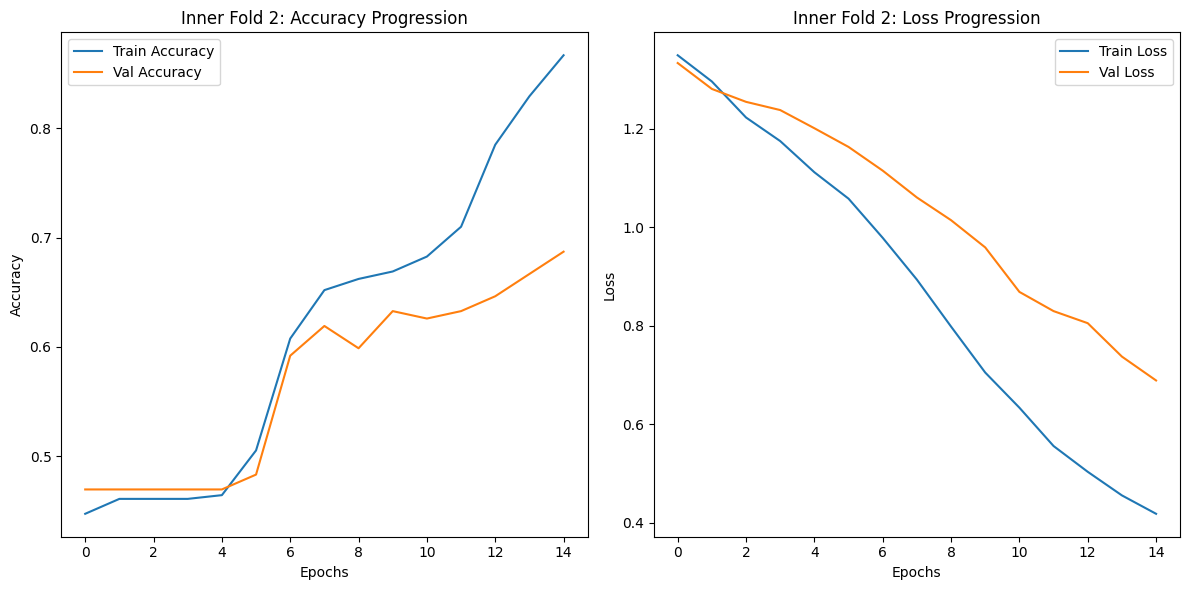

Inner Fold 2: Validation Accuracy = 0.6870748400688171
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 62s 13s/step - accuracy: 0.2182 - loss: 1.4061 - val_accuracy: 0.2808 - val_loss: 1.3999
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 535ms/step - accuracy: 0.4477 - loss: 1.3523 - val_accuracy: 0.4658 - val_loss: 1.3473
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - accuracy: 0.4576 - loss: 1.2937 - val_accuracy: 0.4658 - val_loss: 1.2926
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 570ms/step - accuracy: 0.4576 - loss: 1.2415 - val_accuracy: 0.4658 - val_loss: 1.2373
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 581ms/step - accuracy: 0.4576 - loss: 1.2057 - val_accuracy: 0.4658 - val_loss: 1.2018
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 572ms/step - accuracy: 0.4576 - loss: 1.1644 - val_accuracy: 0.4658 - val_loss: 1.1746
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 570ms/step - accuracy: 0.4741 - loss: 1.1144 - val_accuracy: 0.4932 - val_loss: 1.1146
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0

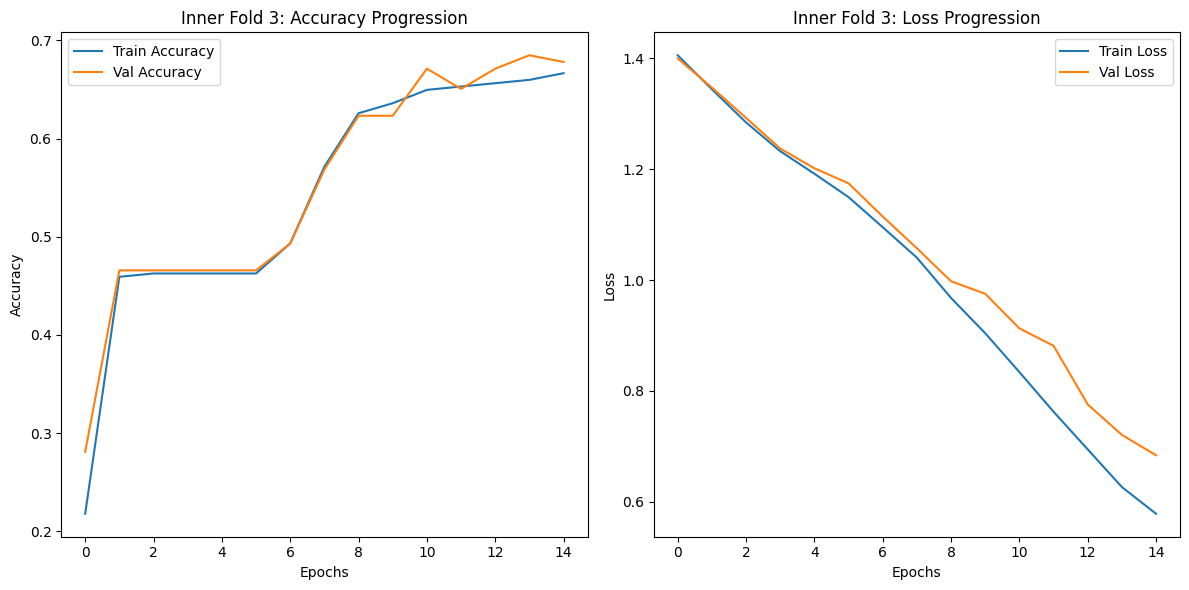

Inner Fold 3: Validation Accuracy = 0.6780821681022644
Outer Fold 1: Test Accuracy = 0.6818181872367859
Outer Fold 2: Using Gamma Value = 1.4
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.4630 - loss: 1.3353 - val_accuracy: 0.4150 - val_loss: 1.3443
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 565ms/step - accuracy: 0.4723 - loss: 1.2763 - val_accuracy: 0.4150 - val_loss: 1.3363
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 587ms/step - accuracy: 0.4735 - loss: 1.2254 - val_accuracy: 0.4150 - val_loss: 1.3552
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 584ms/step - accuracy: 0.4735 - loss: 1.2062 - val_accuracy: 0.4150 - val_loss: 1.3614
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - accuracy: 0.4723 - loss: 1.1733 - val_accuracy: 0.4150 - val_loss: 1.3114
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - accuracy: 0.4723 - loss: 1.1156 - val_accuracy: 0.4150 - val_loss: 1.2862
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 571ms/step - accuracy: 0.4723 - loss: 1.0677 - val_accuracy: 0.4

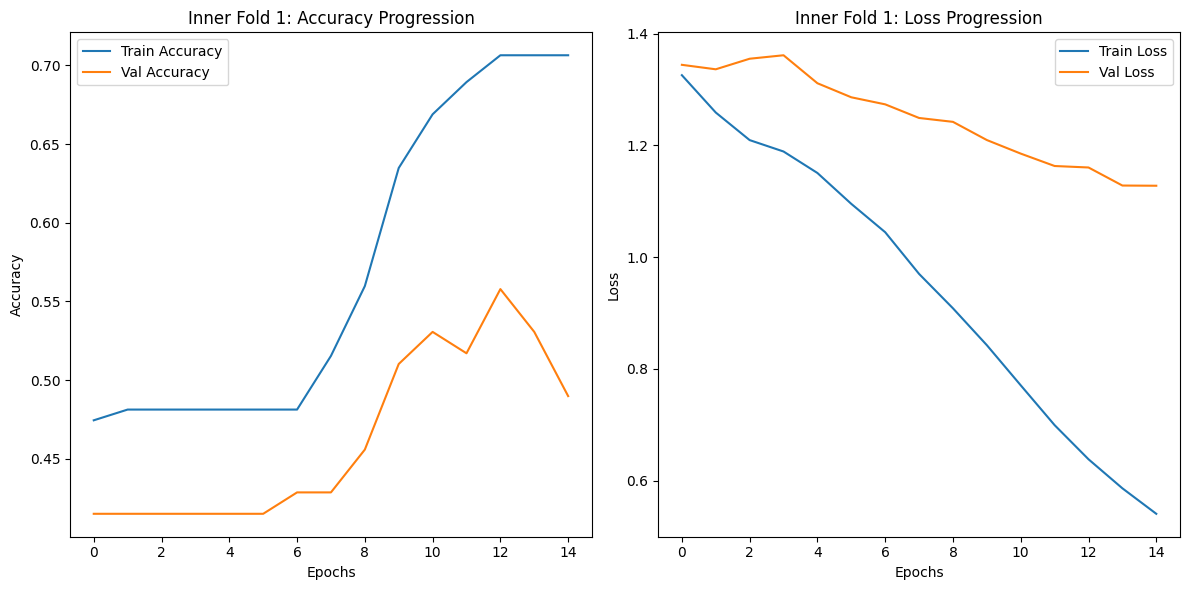

Inner Fold 1: Validation Accuracy = 0.4897959232330322
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.3602 - loss: 1.3666 - val_accuracy: 0.4830 - val_loss: 1.3412
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 533ms/step - accuracy: 0.4440 - loss: 1.3422 - val_accuracy: 0.4830 - val_loss: 1.2959
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - accuracy: 0.4444 - loss: 1.2991 - val_accuracy: 0.4830 - val_loss: 1.2559
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 563ms/step - accuracy: 0.4444 - loss: 1.2571 - val_accuracy: 0.4830 - val_loss: 1.2324
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 584ms/step - accuracy: 0.4440 - loss: 1.2149 - val_accuracy: 0.4830 - val_loss: 1.2261
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 586ms/step - accuracy: 0.4440 - loss: 1.1730 - val_accuracy: 0.4830 - val_loss: 1.2160
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 589ms/step - accuracy: 0.4440 - loss: 1.1369 - val_accuracy: 0.4830 - val_loss: 1.1985
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.

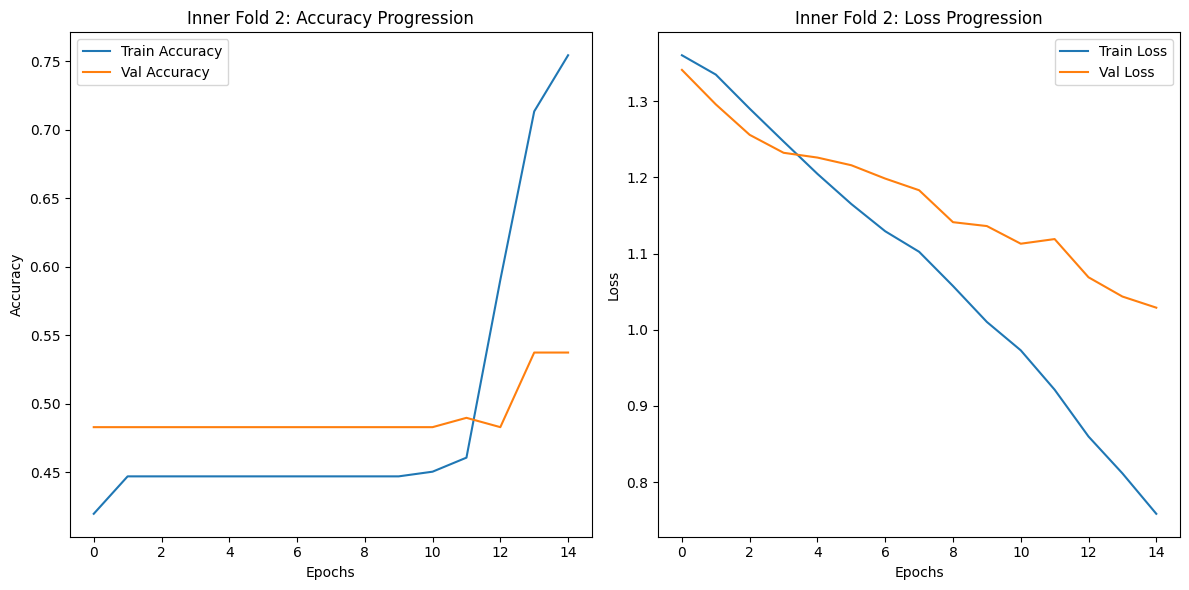

Inner Fold 2: Validation Accuracy = 0.5374149680137634
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.1496 - loss: 1.4250 - val_accuracy: 0.3014 - val_loss: 1.3642
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3373 - loss: 1.3683 - val_accuracy: 0.4795 - val_loss: 1.3126
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 556ms/step - accuracy: 0.4515 - loss: 1.2874 - val_accuracy: 0.4795 - val_loss: 1.2818
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step - accuracy: 0.4515 - loss: 1.2288 - val_accuracy: 0.4795 - val_loss: 1.2660
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 577ms/step - accuracy: 0.4512 - loss: 1.1831 - val_accuracy: 0.4795 - val_loss: 1.2585
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 589ms/step - accuracy: 0.4512 - loss: 1.1338 - val_accuracy: 0.4795 - val_loss: 1.2588
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step - accuracy: 0.4515 - loss: 1.1167 - val_accuracy: 0.4795 - val_loss: 1.2263
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 580ms/step - accuracy: 0.451

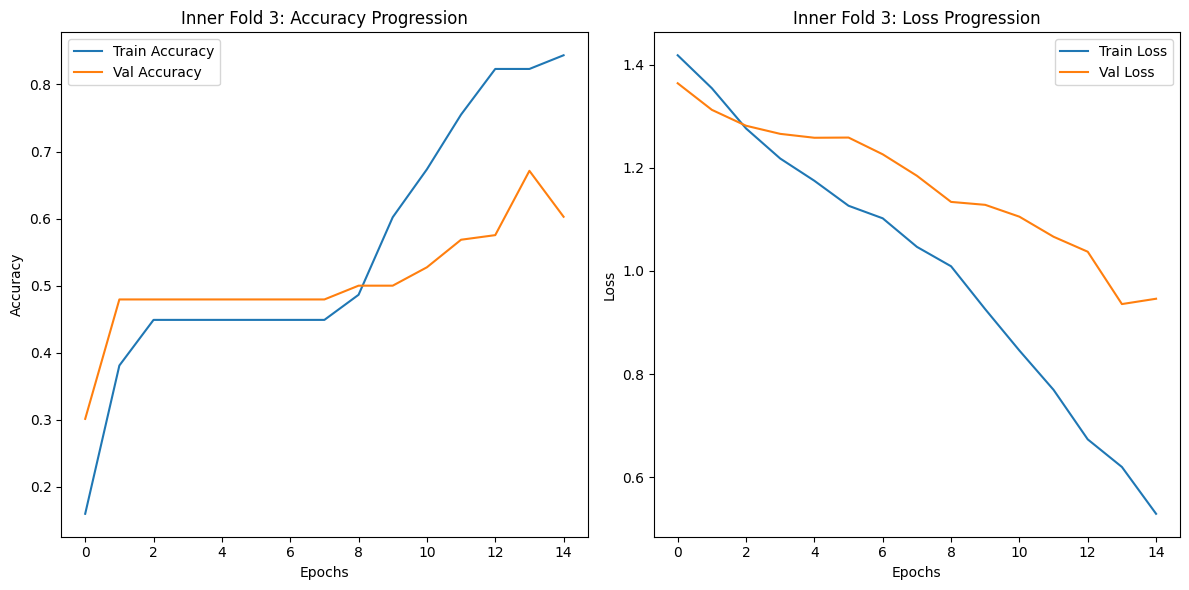

Inner Fold 3: Validation Accuracy = 0.602739691734314
Outer Fold 2: Test Accuracy = 0.5181818008422852
Outer Fold 3: Using Gamma Value = 1.5
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.3757 - loss: 1.3705 - val_accuracy: 0.4762 - val_loss: 1.3493
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step - accuracy: 0.4483 - loss: 1.3079 - val_accuracy: 0.4762 - val_loss: 1.3041
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step - accuracy: 0.4522 - loss: 1.2495 - val_accuracy: 0.4762 - val_loss: 1.2783
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 572ms/step - accuracy: 0.4525 - loss: 1.2001 - val_accuracy: 0.4762 - val_loss: 1.2608
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 573ms/step - accuracy: 0.4525 - loss: 1.1784 - val_accuracy: 0.4762 - val_loss: 1.2519
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 584ms/step - accuracy: 0.4522 - loss: 1.1405 - val_accuracy: 0.4762 - val_loss: 1.2295
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step - accuracy: 0.4525 - loss: 1.0983 - val_accuracy: 0.47

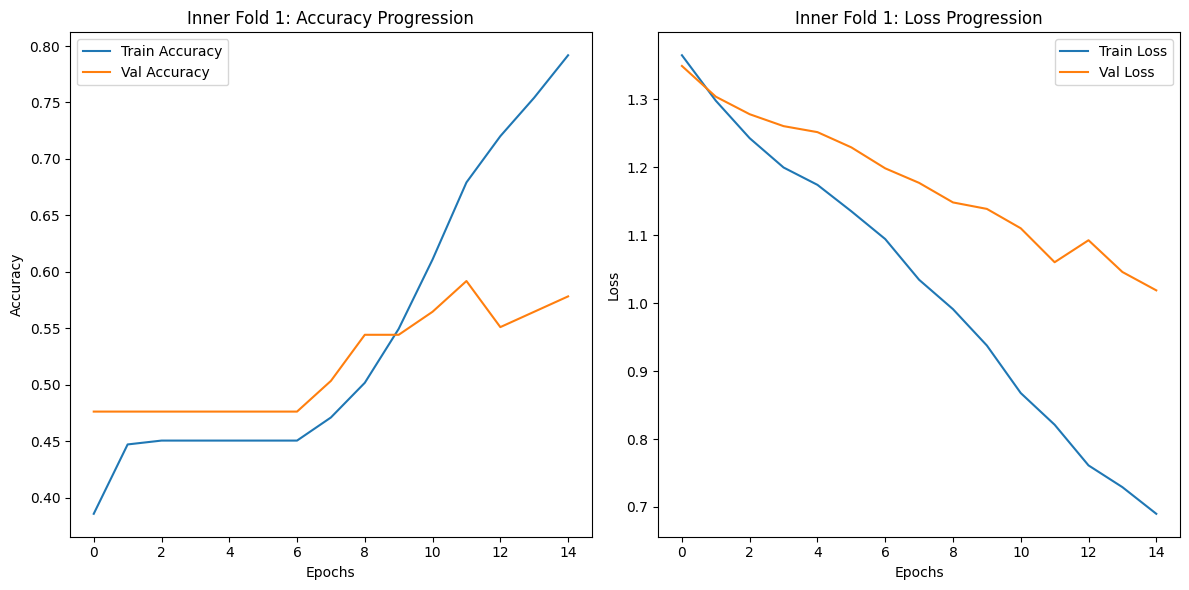

Inner Fold 1: Validation Accuracy = 0.5782312750816345
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.2761 - loss: 1.3711 - val_accuracy: 0.3878 - val_loss: 1.3901
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 528ms/step - accuracy: 0.4629 - loss: 1.3147 - val_accuracy: 0.4082 - val_loss: 1.3553
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 536ms/step - accuracy: 0.4695 - loss: 1.2566 - val_accuracy: 0.4082 - val_loss: 1.3534
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step - accuracy: 0.4695 - loss: 1.2062 - val_accuracy: 0.4082 - val_loss: 1.3290
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 541ms/step - accuracy: 0.4695 - loss: 1.1649 - val_accuracy: 0.4082 - val_loss: 1.3258
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - accuracy: 0.4695 - loss: 1.1062 - val_accuracy: 0.4082 - val_loss: 1.2722
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - accuracy: 0.4819 - loss: 1.0511 - val_accuracy: 0.4150 - val_loss: 1.2194
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - accuracy: 0.

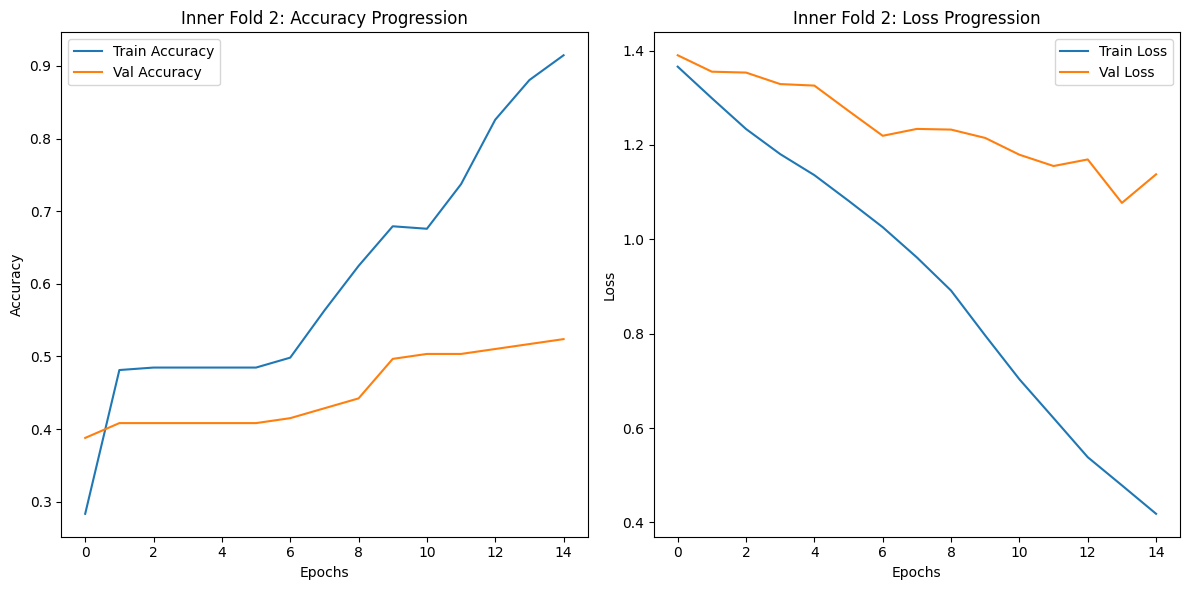

Inner Fold 2: Validation Accuracy = 0.5238094925880432
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.2336 - loss: 1.3867 - val_accuracy: 0.4863 - val_loss: 1.3388
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 470ms/step - accuracy: 0.4173 - loss: 1.3511 - val_accuracy: 0.4932 - val_loss: 1.3251
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - accuracy: 0.4655 - loss: 1.2990 - val_accuracy: 0.4932 - val_loss: 1.2798
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - accuracy: 0.4532 - loss: 1.2438 - val_accuracy: 0.4932 - val_loss: 1.2511
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 0.4532 - loss: 1.1961 - val_accuracy: 0.4932 - val_loss: 1.2318
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.4561 - loss: 1.1463 - val_accuracy: 0.4932 - val_loss: 1.2052
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - accuracy: 0.4934 - loss: 1.0824 - val_accuracy: 0.4932 - val_loss: 1.1997
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 0.

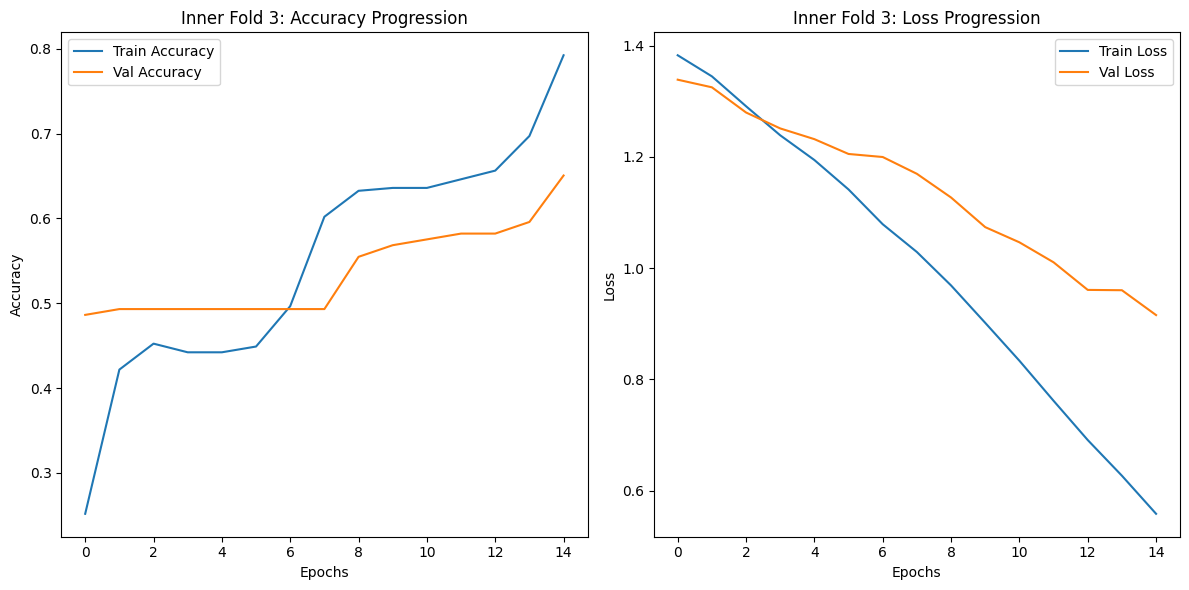

Inner Fold 3: Validation Accuracy = 0.6506849527359009
Outer Fold 3: Test Accuracy = 0.5636363625526428
Best Gamma Value: 1.2, with Average Accuracy: 0.6818


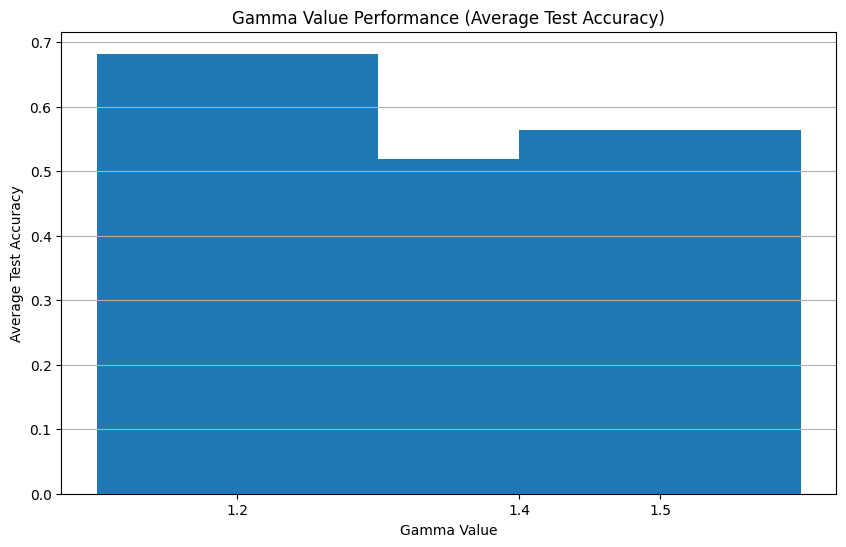

In [ ]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

gamma_values = [1.2, 1.4, 1.5] 
EPOCHS = 15
NUM_CLASSES = 4
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (224, 224)  

# Nested CV setup
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Store results
outer_results = []
gamma_results = {gamma: [] for gamma in gamma_values} 
validation_histories = []  

def augment_dataset(images, labels, gamma_value):
    gamma_images = tf.image.adjust_gamma(images, gamma=gamma_value).numpy()
    augmented_images = np.concatenate((images, gamma_images), axis=0)
    augmented_labels = np.concatenate((labels, labels), axis=0)
    return augmented_images, augmented_labels

def load_dataset(directory, image_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=image_size,
        label_mode="int",
        batch_size=None,  
    )
    images = []
    labels = []
    for image, label in dataset:
        images.append(image)
        labels.append(label)
    images = np.stack(images)
    labels = np.array(labels)
    return images, labels

# Read dataset
images, labels = load_dataset("/content/drive/MyDrive/praeciso/tt", IMAGE_SIZE)
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Outer CV loop
for outer_fold, (train_val_idx, test_idx) in enumerate(outer_cv.split(images)):
    gamma_value = gamma_values[outer_fold % len(gamma_values)] 
    print(f"Outer Fold {outer_fold + 1}: Using Gamma Value = {gamma_value}")

    X_train_val, X_test = images[train_val_idx], images[test_idx]
    y_train_val, y_test = labels[train_val_idx], labels[test_idx]

    aug_train_val_images, aug_train_val_labels = augment_dataset(X_train_val, y_train_val, gamma_value)

    best_inner_model = None
    best_inner_accuracy = 0

    # Inner CV loop
    for inner_fold, (train_idx, val_idx) in enumerate(inner_cv.split(aug_train_val_images)):
        X_train, X_val = aug_train_val_images[train_idx], aug_train_val_images[val_idx]
        y_train, y_val = aug_train_val_labels[train_idx], aug_train_val_labels[val_idx]

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size).prefetch(AUTOTUNE)

        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)

        base_model = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet", num_classes=4, trainable=True)
        inputs = tf.keras.Input(shape=(224, 224, 3))
        x = base_model(inputs)
        outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
        model = tf.keras.Model(inputs, outputs)

        total_images = len(aug_train_val_images)
        total_steps = (total_images // BATCH_SIZE) * EPOCHS
        warmup_steps = int(0.1 * total_steps)
        hold_steps = int(0.45 * total_steps)
        schedule = WarmUpCosineDecay(
            start_lr=0.05,
            target_lr=1e-2,
            warmup_steps=warmup_steps,
            total_steps=total_steps,
            hold=hold_steps,
        )

        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
            metrics=["accuracy"],
        )

        # Train the model
        history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=1)

        training_accuracies = history.history["accuracy"]
        validation_accuracies = history.history["val_accuracy"]
        training_losses = history.history["loss"]
        validation_losses = history.history["val_loss"]

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(training_accuracies, label="Train Accuracy")
        plt.plot(validation_accuracies, label="Val Accuracy")
        plt.title(f"Inner Fold {inner_fold + 1}: Accuracy Progression")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(training_losses, label="Train Loss")
        plt.plot(validation_losses, label="Val Loss")
        plt.title(f"Inner Fold {inner_fold + 1}: Loss Progression")cuoca
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()

        val_accuracy = history.history["val_accuracy"][-1]
        print(f"Inner Fold {inner_fold + 1}: Validation Accuracy = {val_accuracy}")

        if val_accuracy > best_inner_accuracy:
            best_inner_accuracy = val_accuracy
            best_inner_model = model.get_weights()

    best_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    best_model.set_weights(best_inner_model)

    best_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=schedule, momentum=0.9, weight_decay=5e-4),
        metrics=["accuracy"],
    )

    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)
    test_accuracy = best_model.evaluate(test_dataset, verbose=0)[1]
    print(f"Outer Fold {outer_fold + 1}: Test Accuracy = {test_accuracy}")
    outer_results.append(test_accuracy)

    gamma_results[gamma_value].append(test_accuracy)

# Aggregate results by gamma value
average_gamma_results = {gamma: np.mean(acc) for gamma, acc in gamma_results.items()}
best_gamma = max(average_gamma_results, key=average_gamma_results.get)
print(f"Best Gamma Value: {best_gamma}, with Average Accuracy: {average_gamma_results[best_gamma]:.4f}")

# Plot gamma performance
plt.figure(figsize=(10, 6))
plt.bar(average_gamma_results.keys(), average_gamma_results.values(), width=0.2)
plt.title("Gamma Value Performance (Average Test Accuracy)")
plt.xlabel("Gamma Value")
plt.ylabel("Average Test Accuracy")
plt.xticks(list(average_gamma_results.keys()))
plt.grid(axis="y")
plt.show()
